## Modelado data NSCLC Radiogenomics

### *Seminarios Data Science para Radiología*
* **Dr. Héctor Henríquez Leighton**
* **Clínica Santa María - Universidad de los Andes**

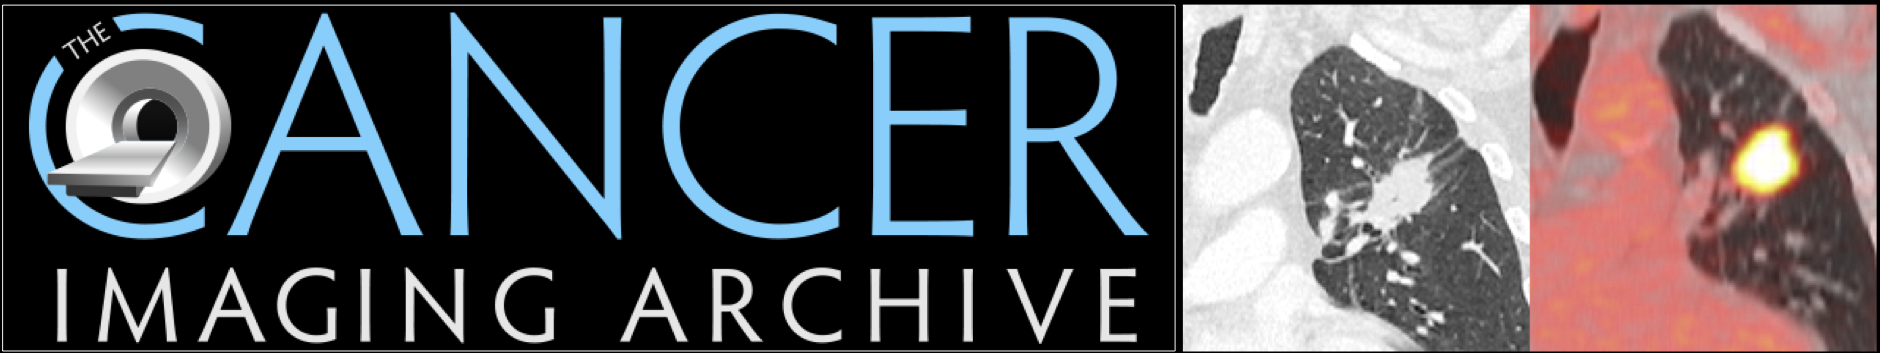

Este set de datos se encuentra disponible en repositorio TCIA

https://wiki.cancerimagingarchive.net/display/Public/NSCLC+Radiogenomics#286723473c084d6d0ed84710b8e77f80a09e9a75

Referencia:
Bakr, S., Gevaert, O., Echegaray, S., Ayers, K., Zhou, M., Shafiq, M., Zheng, H., Zhang, W., Leung, A., Kadoch, M., Shrager, J., Quon, A., Rubin, D., Plevritis, S., & Napel, S. (2017). Data for NSCLC Radiogenomics (Version 4) [Data set]. The Cancer Imaging Archive. https://doi.org/10.7937/K9/TCIA.2017.7hs46erv

In [ ]:
import sys
!{sys.executable} -m pip install missingno

In [ ]:
## Cargar Librerias Relevantes

## Manejo de datos generales
import pandas as pd
import numpy as np
import joblib
from collections import Counter

# Visualización
from plotnine import*
import matplotlib.pyplot as plt

# Modelamiento de datos
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from sklearn.model_selection import train_test_split, KFold,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics as mt
from sklearn import datasets
import statsmodels.api as sm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from scipy import stats
from scipy.stats import mannwhitneyu, shapiro
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

## Medición de timpo y flujo de trabajo
import time
from tqdm import trange

## Sistema
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)
from IPython.display import clear_output


In [ ]:
#Funcion para graficar matriz de confusion
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    #Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')


    #Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

#np.set_printoptions(precision=2)

In [ ]:
url = 'https://raw.githubusercontent.com/HectorHenriquez/NSCLC-Radiogenomics/master/DATA_NSCLC_RADIOGENOMICS_CT_FEATURES.csv'

data = pd.read_csv(url) 

## Previsualización de tabla de datos:
### head es un método del objeto "dataframe" que nos permite visualizar los primeros valores de un dataframe 
data.head(6) 

In [ ]:
data.columns

In [ ]:
data.describe()

In [ ]:
data.isnull().sum()

In [ ]:
### Preparar etiqueta
Counter(data['EGFR'])

In [ ]:
(
 ggplot(data)+
 aes(x='factor(EGFR)', fill='factor(EGFR)')+
 geom_bar()+
 theme_bw() +
 coord_flip() +
 labs(title='Distribución de mutación EGFR en nuestra muestra', x='Mutación de EGFR', fill='EGFR status' )

)

In [ ]:
## Matriz de correlaciones

## En la matriz de correlaciones se pueden ver algunas variables que estan fuertemente correlacionadas entre ellas.

f = plt.figure(figsize=(15, 15))
plt.matshow(data.iloc[:,2:30].corr(), fignum=f.number, cmap='Blues')
plt.xticks(range(data.iloc[:,2:30].select_dtypes(['number']).shape[1]), data.iloc[:,2:30].select_dtypes(['number']).columns, fontsize=12, rotation=50)
plt.yticks(range(data.iloc[:,2:30].select_dtypes(['number']).shape[1]), data.iloc[:,2:30].select_dtypes(['number']).columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)
plt.show()

In [ ]:

## Separamos los datos en variables X, y
X = data.iloc[:,2:]
y = data.iloc[:,1]

## subconjuntos de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=51)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
## Primer modelo
logreg = LogisticRegression(solver='newton-cg')

logreg.fit(X_train, y_train)
y_pred_train = logreg.predict(X_train)
y_pred = logreg.predict(X_test)

#print("Set de Entrenamiento:")
#print(classification_report(y_train,y_pred_train ))

print("Set de Prueba:")
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, normalize=False, classes = ['wildtype', 'mutant'], title='Confusion matrix')
plt.show()

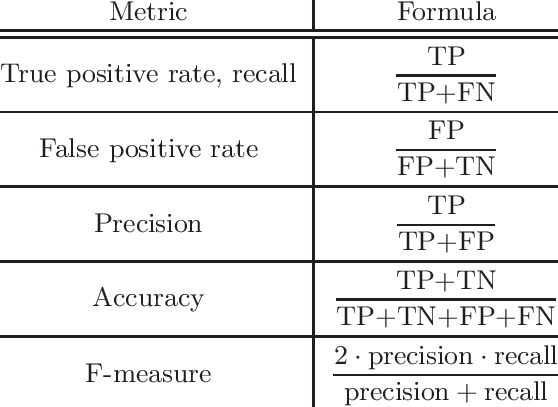

## Modelo usando variables significativas obtenidas de test de medias

In [ ]:

indice_significativo = []
var_sig = []
egfr_wildtype = []
egfr_mutant = []
p_value = []

for i in range(2,len(data[data['EGFR'] == 1].columns)):
    var = data[data['EGFR'] == 1].columns[i]
    x = data[data['EGFR'] == 0][var].dropna()
    y = data[data['EGFR'] == 1][var].dropna()

    shapiro_test = stats.shapiro(x)
    if (shapiro_test[1] < 0.05): ## entonces distribucion no es normal
        U1, p = mannwhitneyu(x, y)

    else:
        st, p = stats.ttest_ind(x, y, equal_var=False)

    promedio_x = str(round(x.mean(),4)) + ' (+/-' + str(round(x.std(),4)) +')'
    promedio_y = str(round(y.mean(),4)) + ' (+/-' + str(round(y.std(),4)) +')'
    egfr_wildtype.append(promedio_x)
    egfr_mutant.append(promedio_y)

    if (p < 0.05):
        valor_p = (round(p,5))
        if(p < 0.001):
            valor_p = str('<0.001')
    else:
        valor_p = (round(p,5))
    p_value.append(valor_p)

    if (p < 0.05):
        indice_significativo.append(i)
        var_sig.append(var)

df = pd.DataFrame(columns=['Variable', 'EGFR Wildtype', 'EGFR mutant', 'valor p'])
df['Variable'] = data[data['EGFR'] == 1].columns[2:]
df['EGFR Wildtype'] = egfr_wildtype
df['EGFR mutant'] = egfr_mutant
df['valor p'] = p_value

df.head(50)

In [ ]:
## modelos univariados:

p = 0.05

variables_significativas = df[df['valor p'] < p]['Variable']

print("variables significativas:\n", variables_significativas)
df[df['valor p'] < p]

In [ ]:
data_significativa = data.loc[:,variables_significativas]
data_significativa.insert(loc=0,
                         column='EGFR',
                         value=data['EGFR'])

data_significativa

In [ ]:
## Segundo Modelo usando variables significativas

## Separamos los datos en variables X, y
X = data_significativa.iloc[:,1:]
y = data_significativa.iloc[:,0]

## subconjuntos de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=51)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
## Primer modelo
logreg = LogisticRegression(solver='newton-cg')

logreg.fit(X_train, y_train)
y_pred_train = logreg.predict(X_train)
y_pred = logreg.predict(X_test)

print("Set de Entrenamiento:")
print(classification_report(y_train,y_pred_train ))

print("Set de Prueba:")
print(classification_report(y_test, y_pred))

In [ ]:

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("Prevalencia poblacional de mutación:", round(Counter(y_test)[1] / Counter(y_test)[0],3))
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
#print ("TFN:", fn/(fn+tp))
#print("TFP:", fp/(fp+tn))
print("Valor predictivo Positivo:", tp/(tp + fp))
print("Valor predictivo Negativo:", tn/(tn + fn))
print("Total casos positivos Modelo:", (fp + tp) / (tp + fp+tn+fn))

plot_confusion_matrix(y_test, y_pred, normalize=False, classes = ['wildtype', 'mutant'], title='Confusion matrix')

## Selección recursiva de variables

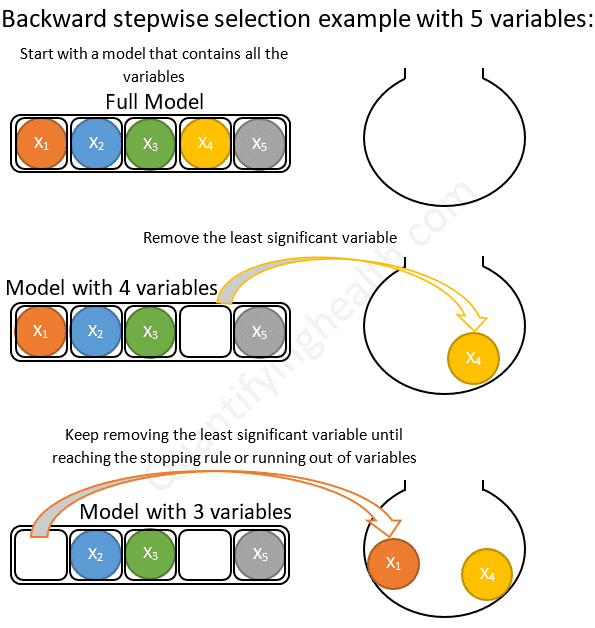

In [ ]:
### Selección recursiva de variables

## Tomamos todas las variables
## Separamos los datos en variables X, y
X = data.iloc[:,2:]
y = data.iloc[:,1]

## subconjuntos de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=51)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:


start = time.time()

clf = LogisticRegression(solver='newton-cg', max_iter=500, class_weight='balanced')

numero_features = 10

#feature selection
feature_selector = sfs(clf,
           k_features= numero_features,
           forward=True,
           floating=False,
           verbose=0,
           scoring='f1',
           cv=5)

# Perform SFFS
feature_selector = feature_selector.fit(X.values, y)
print("Tiempo total de iteración:{} minutos".format((time.time() - start)/60))

In [ ]:
fig1 = plot_sfs(feature_selector.get_metric_dict(), kind='std_dev')

plt.ylim(0.5,1.0)
plt.title('Sequential Feature Backward Selection Random Forest Results:')
plt.grid()
plt.show()

In [ ]:
resultados_sfs = pd.DataFrame(feature_selector.subsets_)
features_select = X.columns[list(resultados_sfs[6]['feature_idx'])]
print(features_select)

# features_select = ['original_shape_MinorAxisLength', 'original_firstorder_10Percentile',
#        'original_firstorder_90Percentile', 'original_firstorder_Skewness',
#       'original_glcm_Id', 'original_glrlm_RunPercentage']

In [ ]:
## Primer modelo
logreg = LogisticRegression(solver='newton-cg')
#logreg = LogisticRegression(solver='saga')

logreg.fit(X_train.loc[:,features_select], y_train)
y_pred = logreg.predict(X_test.loc[:,features_select])

print(classification_report(y_test, y_pred))

In [ ]:

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("Prevalencia poblacional de mutación:", round(Counter(y_test)[1] / Counter(y_test)[0],3))
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print ("TFN:", fn/(fn+tp))
print("TFP:", fp/(fp+tn))
print("Valor predictivo Positivo:", tp/(tp + fp))
print("Valor predictivo Negativo:", tn/(tn + fn))
print("Total casos positivos Modelo:", (fp + tp) / (tp + fp+tn+fn))

plot_confusion_matrix(y_test, y_pred, normalize=False, classes = ['wildtype', 'mutant'], title='Confusion matrix')

## Eligiendo hiperparámetros de un modelo

* Árbol de decisión



In [ ]:

## Tomamos todas las variables
## Separamos los datos en variables X, y
X = data.iloc[:,2:]
y = data.iloc[:,1]

## subconjuntos de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=51)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

DT = DecisionTreeClassifier(max_depth=5)
DT.fit(X_train, y_train)
y_pred = DT.predict(X_test)

print(classification_report(y_test, y_pred))

In [ ]:
all_metrics = []

for i in range(1,20):

  DT = DecisionTreeClassifier(max_depth=i, class_weight= 'balanced')
  DT.fit(X_train, y_train)
  y_pred = DT.predict(X_test)
  F1_test = mt.f1_score(y_test,y_pred, pos_label=1, average='binary',zero_division = 0)
  all_metrics.append(F1_test)


##Graficar rendimiento
(
   ggplot() +
   aes(x=list(range(1,20)), y=all_metrics) +
   geom_line() +
   theme_bw()+
   labs(title='F1 Score versus profundidad del árbol', x='Profundidad', y='F1')+
   scale_x_continuous(breaks=list(range(1,20)))
)

In [ ]:

DT = DecisionTreeClassifier(max_depth=12)
DT.fit(X_train, y_train)
y_pred = DT.predict(X_test)

print(classification_report(y_test, y_pred))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("Prevalencia poblacional de mutación:", round(Counter(y_test)[1] / Counter(y_test)[0],3))
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print ("TFN:", fn/(fn+tp))
print("TFP:", fp/(fp+tn))
print("Valor predictivo Positivo:", tp/(tp + fp))
print("Valor predictivo Negativo:", tn/(tn + fn))
print("Total casos positivos Modelo:", (fp + tp) / (tp + fp+tn+fn))

plot_confusion_matrix(y_test, y_pred, normalize=False, classes = ['wildtype', 'mutant'], title='Confusion matrix')
plt.show()

In [ ]:

DT = DecisionTreeClassifier(max_depth=12)
DT.fit(X_train.loc[:,features_select], y_train)
y_pred = DT.predict(X_test.loc[:,features_select])

print(classification_report(y_test, y_pred))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("Prevalencia poblacional de mutación:", round(Counter(y_test)[1] / Counter(y_test)[0],3))
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print ("TFN:", fn/(fn+tp))
print("TFP:", fp/(fp+tn))
print("Valor predictivo Positivo:", tp/(tp + fp))
print("Valor predictivo Negativo:", tn/(tn + fn))
print("Total casos positivos Modelo:", (fp + tp) / (tp + fp+tn+fn))

plot_confusion_matrix(y_test, y_pred, normalize=False, classes = ['wildtype', 'mutant'], title='Confusion matrix')
plt.show()


In [ ]:
### Hiperparámetros


start = time.time()

parameters = {'max_depth': list(range(1,30,1)), 'criterion':['gini', 'entropy'], 'splitter': ['best', 'random'],
              'min_samples_split': list(range(2,5)), 'min_samples_leaf': list(range(2,6)), 'class_weight': ['balanced']
                                                                              }


DT = DecisionTreeClassifier()


grid = GridSearchCV(DT, parameters, refit = True, verbose=1, cv=5, n_jobs=-1, scoring='f1')

grid.fit(X,y)

end= time.time()
print("tiempo total de iteración:", (end-start)/60, 'minutos')
print(grid.best_params_)

In [ ]:
## Mejores parámetros
grid.best_params_